In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from scipy.stats import ortho_group
from sklearn.decomposition import PCA

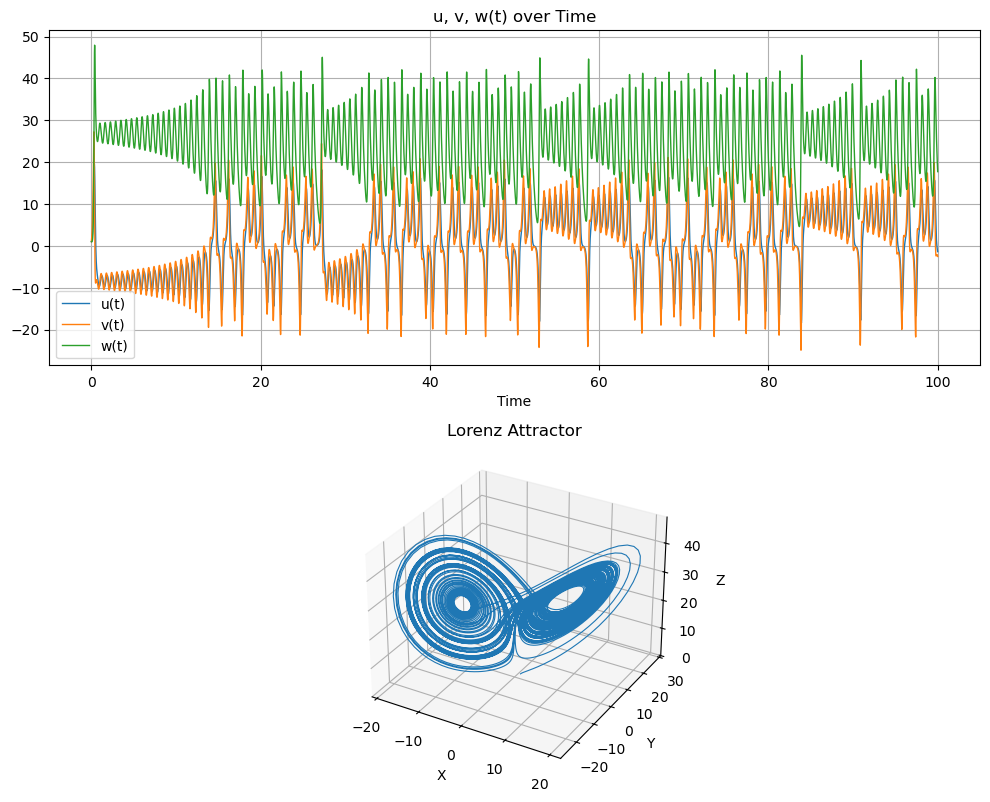

In [2]:
# Lorenz system parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

def lorenz(t, state):
    u, v, w = state
    dudt = sigma * (v - u)
    dvdt = u * (rho - w) - v
    dwdt = u * v - beta * w
    return [dudt, dvdt, dwdt]

M = 10000
state0 = [1.0, 1.0, 1.0]
t_span = (0, 100)
t_eval = np.linspace(t_span[0], t_span[1], M)

sol = solve_ivp(lorenz, t_span, state0, t_eval=t_eval)
t = sol.t
u, v, w = sol.y

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax1.plot(t, u, label='u(t)', lw=1)
ax1.plot(t, v, label='v(t)', lw=1)
ax1.plot(t, w, label='w(t)', lw=1)
ax1.set_title("u, v, w(t) over Time")
ax1.set_xlabel("Time")
ax1.legend()
ax1.grid(True)

ax2 = fig.add_subplot(212, projection='3d')
ax2.plot(u, v, w, lw=0.8)
ax2.set_title("Lorenz Attractor")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
plt.tight_layout()
plt.savefig("../images/lorenz_system.png", dpi=300)
# plt.show()

In [3]:
N = 20
M = 6000 # length of time series
washout = 1000

np.random.seed(42)
A = 0.9 * ortho_group.rvs(N)
C = np.random.uniform(-1, 1, N); C /= np.linalg.norm(C)
x_states = np.zeros((M, N))

for i in range(1, M):
    x_states[i] = A @ x_states[i-1] + C * u.T[i] # 20x20 @ 20x1 + 20x1 * 1x1

pca = PCA(n_components=3)
real_time = np.arange(washout, M)
x_states_3d = pca.fit_transform(x_states[washout:])
print("PCA completed.")
print(f"Original shape: {x_states.shape}")
print(f"Reduced shape: {x_states_3d.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}") # 查看這三個維度解釋了多少變異量

PCA completed.
Original shape: (6000, 20)
Reduced shape: (5000, 3)
Explained variance ratio: [0.95839661 0.0376828  0.0037099 ]


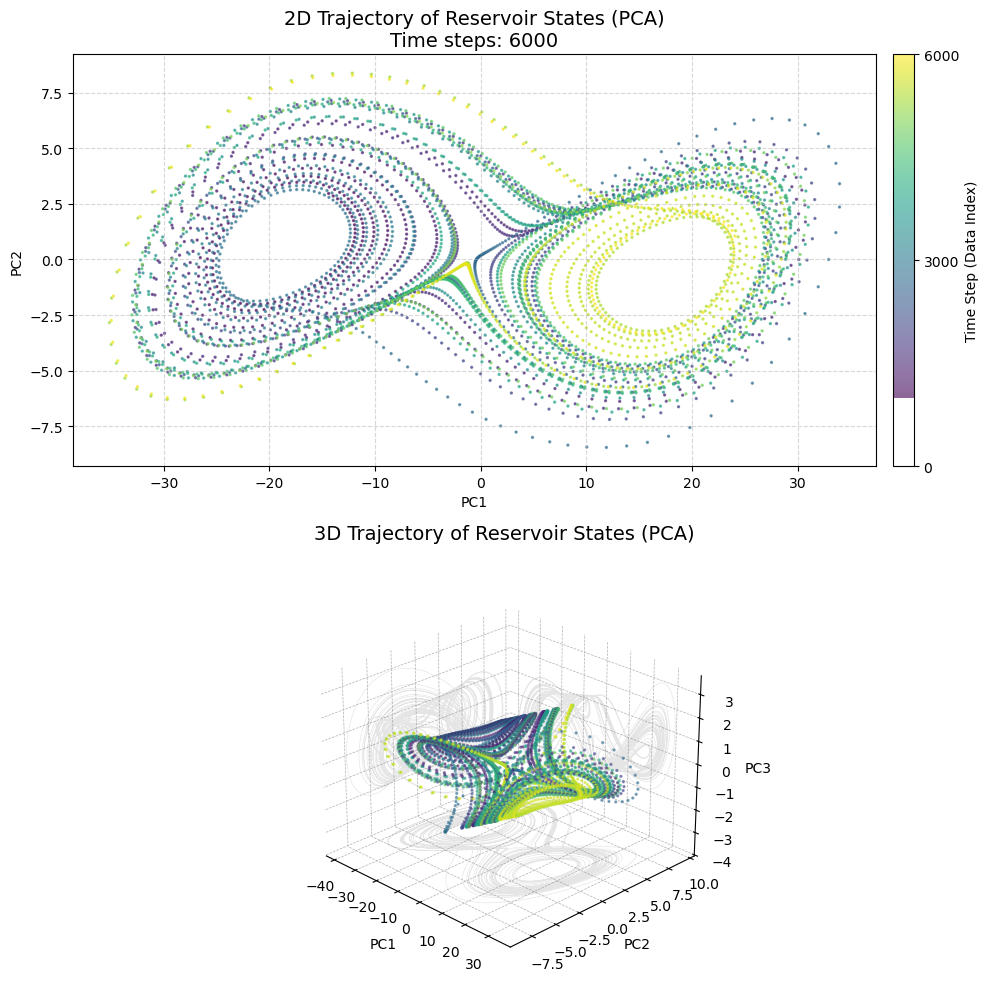

In [4]:
fig = plt.figure(figsize=(10, 10))


ax1 = fig.add_subplot(211)
ax1.set_title(f'2D Trajectory of Reservoir States (PCA)\nTime steps: {M}', fontsize=14)
sc = ax1.scatter(x_states_3d[:, 0], x_states_3d[:, 1],
                c=real_time, cmap='viridis', s=2, alpha=0.6)

cbar = fig.colorbar(sc, ax=ax1, pad=0.02, fraction=0.05)
cbar.set_label("Time Step (Data Index)")
cbar.set_ticks([0, M//2, M])

ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.grid(True, linestyle='--', alpha=0.5)


ax2 = fig.add_subplot(212, projection='3d')
sc_3d = ax2.scatter(x_states_3d[:, 0], x_states_3d[:, 1], x_states_3d[:, 2],
                    c=real_time, cmap='viridis', s=2, alpha=0.5, depthshade=True)

x_min, x_max = x_states_3d[:, 0].min(), x_states_3d[:, 0].max()
y_min, y_max = x_states_3d[:, 1].min(), x_states_3d[:, 1].max()
z_min, z_max = x_states_3d[:, 2].min(), x_states_3d[:, 2].max()
offset = 1.1

# Draw grid lines on the bounding box
ax2.plot(x_states_3d[:, 0], x_states_3d[:, 1], z_min * offset,
         color='gray', alpha=0.2, lw=0.5, zorder=1)

ax2.plot(x_states_3d[:, 0], y_max * offset, x_states_3d[:, 2],
         color='gray', alpha=0.2, lw=0.5, zorder=1)

ax2.plot(x_min * offset, x_states_3d[:, 1], x_states_3d[:, 2],
         color='gray', alpha=0.2, lw=0.5, zorder=1)


ax2.set_title("3D Trajectory of Reservoir States (PCA)", fontsize=14, pad=20)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")
ax2.view_init(elev=25, azim=-45)

# Customize grid lines
ax2.xaxis._axinfo["grid"].update({"linestyle": "--", "linewidth": 0.5})
ax2.yaxis._axinfo["grid"].update({"linestyle": "--", "linewidth": 0.5})
ax2.zaxis._axinfo["grid"].update({"linestyle": "--", "linewidth": 0.5})

# Make panes transparent
ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))


plt.tight_layout()
plt.savefig("../images/Reservoir_States_PCA_Trajectory_Improved.png", 
            dpi=150, bbox_inches='tight')
# plt.show()

In [5]:
M_anim = len(x_states_3d)
print(f"Total data points: {M_anim}")

STEP = 5
FPS = 30
TAIL_LEN = 100
frames_idx = range(0, M_anim, STEP)
total_frames = len(frames_idx)
print(f"Total frames to generate: {total_frames}")

P1_anim = np.array(u).flatten()[:M_anim]
PCA_anim = x_states_3d

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), gridspec_kw={'height_ratios': [1, 2]})

ax1.plot(np.arange(M_anim), P1_anim, color='gray', alpha=0.5)
ax1.set_xlim(0, M_anim)
ax1.set_ylim(np.min(P1_anim)*1.1, np.max(P1_anim)*1.1)
ax1.set_title('Original Signal (Time Domain)', fontsize=16)
ax1.grid(True, linestyle='--', alpha=0.5)
point_signal, = ax1.plot([], [], 'r.', markersize=10, zorder=5)
time_line = ax1.axvline(x=0, color='r', alpha=0.5, linestyle='--')

ax2.scatter(PCA_anim[:, 0], PCA_anim[:, 1], c=np.arange(M_anim), cmap='viridis', s=3, alpha=0.4)
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_title('Reservoir States Trajectory (PCA)', fontsize=16)
ax2.grid(True, linestyle='--', alpha=0.5)
point_pca, = ax2.plot([], [], 'ro', markersize=8, zorder=10)
tail_pca, = ax2.plot([], [], 'r-', linewidth=1.5, alpha=0.6, zorder=9)


def init():
    point_signal.set_data([], [])
    time_line.set_xdata([0])
    point_pca.set_data([], [])
    tail_pca.set_data([], [])
    return point_signal, time_line, point_pca, tail_pca

def update(frame):
    point_signal.set_data([frame], [P1_anim[frame]])
    time_line.set_xdata([frame])

    point_pca.set_data([PCA_anim[frame, 0]], [PCA_anim[frame, 1]])

    start_idx = max(0, frame - TAIL_LEN)
    tail_pca.set_data(PCA_anim[start_idx : frame+1, 0], PCA_anim[start_idx : frame+1, 1])
    return point_signal, time_line, point_pca, tail_pca

anim = animation.FuncAnimation(fig, update, init_func=init, frames=frames_idx, blit=True)
print("Starting video rendering...")

try:
    anim.save(
        '../images/Reservoir_Dynamics.gif', 
        writer='pillow', 
        fps=FPS, 
        dpi=100,
    )
    print("\n✅ Done! Video saved as Reservoir_Dynamics.gif")

except Exception as e:
    print(f"\n❌ Error: {e}")
    print("Possible causes: ffmpeg path issue, or matplotlib version is too old to support progress_callback.")

plt.close()

Total data points: 5000
Total frames to generate: 1000
Starting video rendering...

✅ Done! Video saved as Reservoir_Dynamics.gif
